In [1]:
import vaex as vx
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import dates as mpl_dates
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import acf, pacf
from sklearn.model_selection import ParameterGrid
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib widget
%load_ext line_profiler

In [2]:
# Imports data
path = os.getcwd()
# vx.from_csv('%s//Data//consumption_data.csv'%path, dtype={'Corporate Facility Name': 'string',
#                                                     'Service Transaction ID': 'string',
#                                                     'Vdl Drug ID':'string'},low_memory=False, chunk_size=100_000)
data = vx.open("%s//Data//consumption_data.csv.hdf5"%path)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
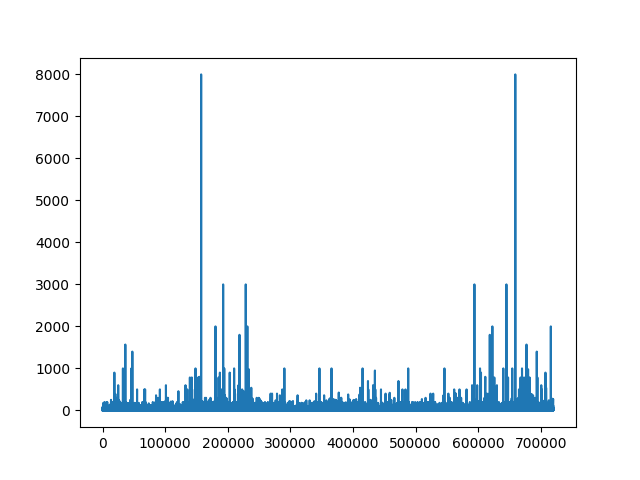

Wall time: 187 ms


In [3]:
%%time
plt.plot(data['Quantity In Units'].to_numpy())
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
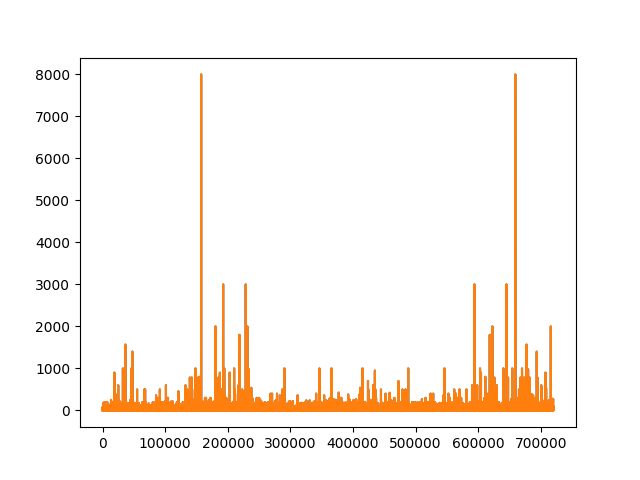

Wall time: 205 ms


In [4]:
%%time
plt.plot(data['Quantity In Units'].values)
plt.show()

In [ ]:
# Viewing Data
display(data.head())
display(data.tail())

In [ ]:
# Changing Datetime types on the Sale Date Column
data['Sale Date'] = data['Sale Date'].astype('datetime64[ns]')
# Place all Column Names in a List
col_names = data.get_column_names()
# Renaming all columns to fit Vaex standards
for i in col_names:
    data.rename(i,i.replace(" ", "_"))
    data.rename(i, i.replace("-","_"))


In [ ]:
col_names = data.get_column_names()

In [ ]:
# Filtering Data to relevant Columns
df = data.copy()[[col_names[2], col_names[4], col_names[5], col_names[6], 
                col_names[9], col_names[10], col_names[11], col_names[12], col_names[13],
                col_names[14], col_names[15],col_names[41], col_names[43], col_names[44], col_names[50]]]

In [ ]:
# Viewing the Relevant Columns
df.get_column_names()
# Sort Time Series
df = df.sort(by='Sale_Date', ascending=True)

In [ ]:
indications = dict(df.groupby('Item_Sub_Category'))
anti_d = indications[('Anti-Diabetics',)]
anti_d = vx.from_arrays(x=anti_d['Sale_Date'].values,y=anti_d['Quantity_In_Units'].values)
anti_d.rename("x", "Sale_Date")
anti_d.rename("y", "Quantity_In_Units")

In [ ]:
weekly = anti_d.groupby(by=vx.BinnerTime(anti_d['Sale_Date'], resolution='W'), agg={'count':'count'})
daily = anti_d.groupby(by=vx.BinnerTime(anti_d['Sale_Date'], resolution='D'), agg={'count':'count'})
monthly = anti_d.groupby(by=vx.BinnerTime(anti_d['Sale_Date'], resolution='M'), agg={'count':'count'})

In [ ]:
def rolling_window(a, window, find_mean, find_std):
    old_shape = a.shape[0]
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    view = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    
    if find_mean:
        final = np.array([view[i,:].mean() for i in range(view.shape[0])])
        
    elif find_std:
        final = np.array([view[i,:].std() for i in range(view.shape[0])])
        
    new_shape = view.shape[0]
    zeros = np.array([0 for x in range(old_shape - new_shape)])
    result = np.concatenate((zeros,final))
    return result

In [ ]:
def plots(x, y, title, date="%b, %d %Y", window=3, xlabel='Date', ylabel='Quantity of Anti_Diabetic Sold in Units', mean=False, std=False, sav=False):
    fig = plt.figure()
    plt.plot_date(x, y, linestyle='solid', marker=None, fmt='g', label='Main Time Series Data')
    if sav:
        plt.plot_date(x, savgol_filter(y,window,3),
                      linestyle='solid', marker=None, fmt='y', label='Saviztky Golay Algo with Window Size of %s'%window)
    if mean:
        plt.plot_date(x, rolling_window(y,window=window,find_mean=True,find_std=False),
                      linestyle='solid', marker=None, fmt='r', label='Moving Average with Window Size of %s'%window)
    if std:
        plt.plot_date(x, rolling_window(y,window=window,find_std=True, find_mean=False),
                      linestyle='solid', marker=None, fmt='b', label='Moving Std with Window Size of %s'%window)
    plt.gcf().autofmt_xdate()
    date_format = mpl_dates.DateFormatter(date)
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
plots(weekly['Sale_Date'].values, weekly['count'].values, "%b, %d %Y", 'Weekly Trend', 5)

In [ ]:
plots(daily['Sale_Date'].values, daily['count'].values, "%b, %d %Y", 'Daily Trend',  5)

In [ ]:
plots(monthly['Sale_Date'].values, monthly['count'].values, "%b, %d %Y", 'Monthly Trend', 5)

In [ ]:
plots(anti_d.sort(by='Sale_Date')['Sale_Date'].values, anti_d.sort(by='Sale_Date')['Quantity_In_Units'].values, "%b, %d %Y", 'Monthly Trend', 5)

In [ ]:
# Adfuller Test to Check for Stationary Datasets
def stat_check(data, ts):
    test = adfuller(data, autolag='AIC')
    results = pd.Series(test[0:4], index=['Test Statistic', 'P-value', '#lags used', 'Number of Observations Used'])
    for key,value in test[4].items():
        results['Critical Value (%s)'%key] = value
    
    print(f'Results of Dickey Fuller Test for {ts} Data \n{results}')


stat_check(weekly['count'].values, "Weekly")
stat_check(monthly['count'].values, "Monthly")
stat_check(daily['count'].values, "Daily")
stat_check(anti_d['Quantity_In_Units'].values, "Hourly")


In [ ]:
# One means of ensuring stationarity is decomposing and taking the residuals
result = seasonal_decompose(monthly['count'].values, period=12)

In [ ]:
plots(monthly['Sale_Date'].values, result.trend, 'Trend')
plots(monthly['Sale_Date'].values, result.seasonal, 'Seasonality')
plots(monthly['Sale_Date'].values, result.resid, 'Residuals')

In [ ]:
monthly = vx.from_arrays(x=monthly["Sale_Date"].values, y=monthly["count"].values)
monthly.rename("x","Sale_Date")
monthly.rename("y","count")

In [ ]:
# Transforming data to ensure stationarity (Log/MA)
monthly['log_data'] = monthly['count'].apply(lambda x: np.log(x))

In [ ]:
monthly.head()

In [ ]:
log_ma = rolling_window(monthly['log_data'].values, 12, find_mean=True, find_std=False)

In [ ]:
plots(monthly['Sale_Date'].values, monthly['log_data'].values, 'Monthly Trend', mean=True, window=12)
stat_check(anti_d['log_data'].values, "Monthly")
# plots(monthly['Sale_Date'].values, rolling_window(monthly['log_data'].values, 12,
#                                                  find_mean=True, find_std=False), "%b, %d %Y", 'Monthly Trend', 5)
stat_check(log_ma, "Mean Log")

In [ ]:
# Differencing
def diff(dataset, interval, col):
    result = []
    for i in range(interval, len(dataset)):
        offset = i - interval
        value = dataset[col].values[i] - dataset[col].values[offset]
        result.append(value)
    return (result)

%lprun -f diff diff(dataset=anti_d, interval=1, col="log_data")

In [ ]:
jot = monthly.diff(column="log_data", fill_value="nan")

In [ ]:
monthly.diff(column="log_data", fill_value="nan")

In [ ]:
monthly["diff"] = jot["log_data"].values

In [ ]:
stat_check(anti_d["log_diff"].values)

In [ ]:
# Determing p and q
lag_acf = acf(anti_d["Quantity_In_Units"].values, nlags=20)
lag_pacf = pacf(anti_d["Quantity_In_Units"].values, nlags=20)

In [ ]:
def plot_acf_pacf(df, ts):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(ts))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(ts))
  
  plt.tight_layout()
  plt.show()  
  return

In [ ]:
plot_acf_pacf(anti_d["Quantity_In_Units"].values, "Data")

In [ ]:
fig,(ax1,ax2)= plt.subplots(1, 2)
ax1 = plot_acf(anti_d["Quantity_In_Units"].values, lags=40, ax=ax1)
ax2 = plot_pacf(anti_d["Quantity_In_Units"].values, lags=40, ax=ax2)

In [ ]:
def run_arima_model(df, dates, p, d, q):
  """
  Run ARIMA model
  """

  # fit ARIMA model on time series
  model = ARIMA(df, order=(p, d, q))  
  results_ = model.fit()  
  
  # get lengths correct to calculate RSS
  len_results = len(results_.fittedvalues)
  ts_modified = df[-len_results:]
  
  # calculate root mean square error (RMSE) and residual sum of squares (RSS)
  rss = sum((results_.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss / len(df))
  
  # plot fit
  fig = plt.figure()
  plt.plot(dates, df)
  plt.plot(dates, results_.fittedvalues, color = 'red')
  plt.title('For ARIMA model (%i, %i, %i) for RSS: %.4f, RMSE: %.4f' %(p, d, q, rss, rmse))
  
  plt.show()  
  return results_

In [ ]:
# Note: I do the differencing in the transformation of the data 'ts_log_diff'
# AR model with 1st order differencing - ARIMA (1,0,0)
model_AR = run_arima_model(df = anti_d.Quantity_In_Units.values,
                           dates = anti_d.Sale_Date.values,
                           p = 1, 
                           d = 0, 
                           q = 0)

# MA model with 1st order differencing - ARIMA (0,0,1)
model_AR = run_arima_model(df = anti_d.Quantity_In_Units.values,
                           dates = anti_d.Sale_Date.values,
                           p = 0, 
                           d = 0, 
                           q = 1)

# ARMA model with 1st order differencing - ARIMA (1,0,1)
model_AR = run_arima_model(df = anti_d.Quantity_In_Units.values,
                           dates = anti_d.Sale_Date.values,
                           p = 1, 
                           d = 0, 
                           q = 1)

In [ ]:
ARIMA(anti_d.Quantity_In_Units.values).fit(disp=-1)

In [ ]:
results = ARIMA(anti_d.Quantity_In_Units.values).fit()

In [ ]:
plt.results.fittedvalues